In [1]:
import numpy as np
import pandas as pd
import swifter
import dask.dataframe as dd

### Generate dataframe with lots of rows

In [13]:
arr = np.random.randint(low=0, high=5, size=(200000, 5))
df = pd.DataFrame(arr, columns=['A', 'B', 'C', 'D', 'E'])
df.to_csv('abcde.csv', index=False)
df.head()

,A,B,C,D,E
0,3,4,0,2,4
1,4,0,2,1,2
2,3,0,3,4,1
3,1,4,4,4,3
4,2,4,0,1,4


### Memory usage of the dataframe

In [7]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   A       200000 non-null  int32
 1   B       200000 non-null  int32
 2   C       200000 non-null  int32
 3   D       200000 non-null  int32
 4   E       200000 non-null  int32
dtypes: int32(5)
memory usage: 3.8 MB


In [15]:
df2_types = {
    'A': np.int16,
    'B': np.int16,
    'C': np.int16,
    'D': np.int16,
    'E': np.int16
}
df2 = pd.read_csv('abcde.csv', dtype=df2_types)
df2.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   A       200000 non-null  int16
 1   B       200000 non-null  int16
 2   C       200000 non-null  int16
 3   D       200000 non-null  int16
 4   E       200000 non-null  int16
dtypes: int16(5)
memory usage: 1.9 MB


### create new column on dataframe with single thread

In [16]:
%%time
df['sum_of_square'] = df.apply(lambda row: row.A ** 2 + row.B ** 2 + row.C ** 2 + row.D ** 2 + row.E ** 2, axis = 1) 

Wall time: 31.6 s


In [18]:
%%time
def calc(row):
    return row.A ** 2 + row.B ** 2 + row.C ** 2 + row.D ** 2 + row.E ** 2

#df['sum_of_square'] = df.apply(lambda x: calc(x), axis=1)

Wall time: 0 ns


### Now use dask

In [10]:
import os
os.cpu_count()

8

In [19]:
%%time
ddf = dd.from_pandas(df, npartitions=8)
df['sum_of_square2'] = ddf.map_partitions(calc).compute()

Wall time: 98 ms


### Swifter

In [20]:
%%time
df['sum_of_square3'] = df.swifter.apply(lambda row:calc(row),axis=1)


Wall time: 33.1 ms


### Other libraries
* modin
* ray

## Do you really need these tools?

In [21]:
%%time
df['sum_of_square4'] = df.A ** 2 + df.B ** 2 + df.C ** 2 + df.D ** 2 + df.E ** 2

Wall time: 17 ms


### Swifter vs Dask

In [22]:
import time
from tqdm import tqdm
size = [100000, 500000, 100000, 500000, 10000000, 20000000, 50000000, 100000000]
d_time = []
s_time = []
p_time = []
for i in tqdm(size):
    arr = np.random.randint(low=0, high=5, size=(i, 5))
    df = pd.DataFrame(arr, columns=['A', 'B', 'C', 'D', 'E'])
    
    # Use dask
    ddf = dd.from_pandas(df, npartitions=8)
    start = time.time()
    df['sum_dask']= ddf.map_partitions(calc).compute()
    duration = time.time() - start
    d_time.append(duration)
    
    # Use swifter
    start = time.time()
    df['sum_swifter'] = df.swifter.apply(lambda row:calc(row),axis=1)
    duration = time.time() - start
    s_time.append(duration)
    
    # use pandas
    start = time.time()
    df['sum_pandas'] = df.A ** 2 + df.B ** 2 + df.C ** 2 + df.D ** 2 + df.E ** 2
    duration = time.time() - start
    p_time.append(duration)
result = pd.DataFrame({
    'Size': size,
    'Dask': d_time,
    'Swifter': s_time,
    'Pandas': p_time
})
result

100%|██████████| 8/8 [01:12<00:00,  9.08s/it]


,Size,Dask,Swifter,Pandas
0,100000,0.056005,0.020995,0.006000
1,500000,0.056994,0.049004,0.031998
2,100000,0.055985,0.020997,0.007003
3,500000,0.046997,0.051002,0.034998
4,10000000,0.377084,0.623129,0.553304
5,20000000,1.041390,1.536002,1.176016
6,50000000,2.038432,3.524530,3.129034
7,100000000,3.658919,6.553787,13.532999


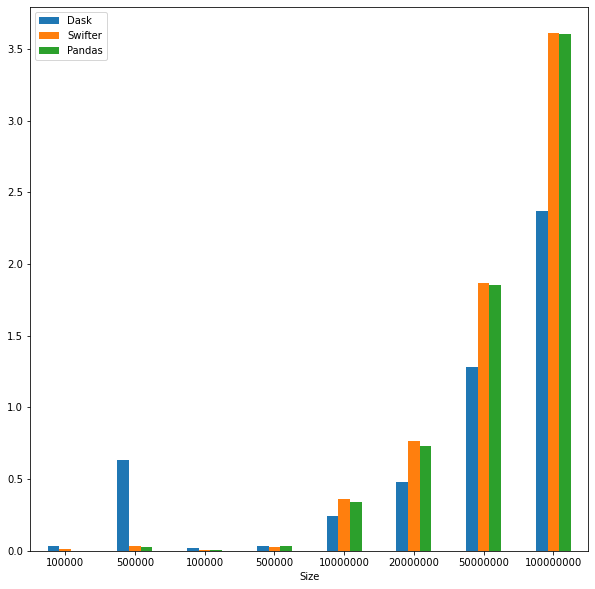

In [25]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)
result.set_index('Size').plot.bar(rot=0)